$$
% transferring macros:
\let\eps\varepsilon
\let\wt\widetilde
\let\tn\mathrm
\let\vphi\varphi
\let\pa\partial
\let\para\parallel
\let\wh\widehat
\let\sl\shoveleft
% defining new macros:
\def\be{\begin{equation} \mskip 1cm}
\def\ee{\end{equation}}
\def\ba{\begin{align} \mskip 1cm}
\def\ea{\end{align}}
\def\RR{{\mathbb R}}
\def\DD{{\mathbb D}}
\def\GG{{\mathbb G}}
\def\CC{{\mathbb C}}
\def\MM{{\mathbb M}}
\def\grad{\tn{grad}\,}
\def\curl{\tn{curl}\,}
\def\div{\tn{div}\,}
\def\Im{\tn{Im}}
% defining new commands:
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\bold}[1]{{\bf #1}}
\newcommand{\pder}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dt}[1]{\frac{\mathrm d #1}{\mathrm dt}}
\newcommand{\ds}[1]{\frac{\mathrm d #1}{\mathrm ds}}
$$

# Maxwell's equations with finite element exterior calculus

## Problem formulation

The aim of this notebook is to explain the finite element discretization of Maxwell's equations based on finite element exterior calculus (FEEC). This method is based on the de Rham complex of finite element spaces: 

<img src="pics/deRham.png" width="550"/> 

This complex is used in the discritzation of Maxwell's equations for the electric field $\bold E$ and the magnetic field $\bold B$:

$$
\ba
 \frac{1}{c^2} \pder{\bold E}{t} - \curl \bold B &= - \mu_0\bold J &&\qquad\quad\tn{(Ampère)} \,, \label{ampere}
 \\[1mm]
 \pder{\bold B}{t} + \curl \bold E &= 0 &&\qquad\quad\tn{(Faraday)} \,,
 \\[1.5mm]
 \div \bold E &= \frac{\varrho}{\eps_0} &&\qquad\quad\tn{(Gauss\,1)} \,, \label{gauss}
 \\[2mm]
 \div \bold B &= 0 &&\qquad\quad\tn{(Gauss\,2)} \,. \label{divB}
\ea
$$

Here, $\bold J$ and $\varrho$ are the given sources, namely the current density and the charge denstiy, respectively. Natural constants are the speed of light $c$, the magnetic constant $\mu_0$ and the dielectric constant $\eps_0$, where $1/c^2 = \eps_0\mu_0$. Taking the divergence of Ampère's law \eqref{ampere}, using that $\div\curl = 0$ and inserting Gauss' law \eqref{gauss} yields

$$
\be
 \pder{\varrho}{t} + \div \bold J = 0\,. \label{charge}
\ee
$$

This is a solvability condition for Maxwell's equations, called "conservation of charge". On the other hand, taking the time derivative of the Gauss law \eqref{gauss}, equation \eqref{charge} implies

$$
\be \label{alltimes}
 \dt{} \left( \div \bold E - \frac{\varrho}{\eps_0} \right) =  \frac{1}{\eps_0\mu_0}\, \div \curl \bold B - \frac{1}{\eps_0} \div \bold J - \frac{1}{\eps_0} \pder{\varrho}{t} = 0\,,
\ee
$$

Similarly,

$$
\be
 \dt{}\, \div \bold B = - \div \curl \bold E = 0\,,
 \ee
$$

which means that the two Gauss laws are satisfied at all times provided that they are satisfied at the initial time. The commuting diagram property of the deRham complex allows for numerical schemes that translate this property to the discrete level exactly (up to machine precision).

Let us start with the one dimensional case (1D). For this we assume that variations of $\bold E$ and $\bold B$ occurr only with respect to the $x$-direction, hence

$$
\be
 \grad = \begin{pmatrix} \pder{}{x} \\ 0 \\ 0  \end{pmatrix} \,,\qquad \curl \bold E = \begin{pmatrix} 0 \\ -\pder{E_z}{x} \\ \pder{E_y}{x} \end{pmatrix}\,,\qquad \div \bold E = \pder{E_x}{x}\,.
\ee
$$

Moreover, let us assume $E_z = B_x = B_y = 0$ and denote $E := E_y$, $J:= J_y$ and $B:= B_z$. Maxwell's equations then read

$$
\ba
 &\frac{1}{c^2} \pder{E_x}{t} = - \mu_0 J_x &&\qquad\quad\tn{(Ampère\,first\,component)} \,, \label{ampere:1Dx}
 \\[1mm]
 &\frac{1}{c^2} \pder{E}{t} + \pder{B}{x} = - \mu_0 J &&\qquad\quad\tn{(Ampère\,second\,component)} \,, \label{ampere:1D}
 \\[1mm]
 &\pder{B}{t} + \pder{E}{x} = 0 &&\qquad\quad\tn{(Faraday)} \,. \label{faraday:1D}
\ea
$$

We assume the domain to be $\Omega = (a,b)$ and suppose homogeneous Dirichlet boundary conditions for $E$ and periodic conditions for $E_x$ and $B$. In order to obtain a weak formulation of \eqref{ampere:1Dx}-\eqref{faraday:1D} we multiply by testfunctions $F_x$, $F$ and $C$ and integrate over $\Omega$:

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_x}{t} F_x\,\tn d x = - \mu_0 \int_a^b J_x F_x\,\tn d x\,, \label{int:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E}{t} F\,\tn d x + \int_a^b \pder{B}{x} F\,\tn d x = - \mu_0 \int_a^b J \,F\,\tn d x\,, 
 \\[1mm]
 &\int_a^b \pder{B}{t} C\,\tn d x + \int_a^b \pder{E}{x} C\,\tn d x = 0\,. \label{int:3}
\ea
$$

There are multiple possibilities to use this for a weak formulation of \eqref{int:1}-\eqref{int:3}. We choose the following: find $(E_x,E,B)\in H^1\times H^1_0 \times L^2$ such that

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_x}{t} F_x\,\tn d x = - \mu_0 \int_a^b J_x F_x\,\tn d x \qquad &&\forall\, F_x \in H^1\,, \label{weak:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E}{t} F\,\tn d x - \int_a^b B\,\pder{F}{x} \,\tn d x = - \mu_0 \int_a^b J \,F\,\tn d x \qquad &&\forall\, F \in H^1_0\,, 
 \\[1mm]
 &\int_a^b \pder{B}{t} C\,\tn d x + \int_a^b \pder{E}{x} C\,\tn d x = 0 \qquad &&\forall\, C \in L^2\,. \label{weak:3}
\ea
$$

Remark that we intgrated by parts in the second equation in order to obtain a well defined weak formulation. 

## Discretization

The problem \eqref{weak:1}-\eqref{weak:3} contains only first order derivatives. Our aim is to choose solution spaces that satisfy a commuting diagram. A simpler 1D version of the above deRham complex reads as follows:

<img src="pics/deRham1D.png" width="220"/>

The projectors $\Pi_0$ and $\Pi_1$ must be chosen such that the diagram is commuting. In particular, for the discrete solution spaces we have $V_0 \subset H^1_0$ and $V_1 \subset L^2$ with $\dim V_0 = N_0 <\infty$ and $\dim V_1 = N_1 < \infty$. The basis functions will be denoted by $(\varphi^0_i)_{1\leq i\leq N_0}$ and $(\varphi^1_{i+1/2})_{0\leq i\leq N_1-1}$, respectively. For periodic boundary conditions we consider a similar diagram with the appropriate spaces and denote everything with a tilde, for example, $\tilde V_0$. The discrete version of problem \eqref{weak:1}-\eqref{weak:3} reads: find $(E_{x,h},E_h,B_h)\in \tilde V_0\times V_0 \times V_1$ such that

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_{x,h}}{t} F_{x,h}\,\tn d x = - \mu_0 \int_a^b (\tilde \Pi_0 J_x) F_{x,h}\,\tn d x \qquad &&\forall\, F_{x,h} \in \tilde V_0\,, \label{disc:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E_h}{t} F_h\,\tn d x - \int_a^b B_h\,\pder{F_h}{x} \,\tn d x = - \mu_0 \int_a^b (\Pi_0 J) \,F_h\,\tn d x \qquad &&\forall\, F_h \in V_0\,, 
 \\[1mm]
 &\int_a^b \pder{B_h}{t} C_h\,\tn d x + \int_a^b \pder{E_h}{x} C_h\,\tn d x = 0 \qquad &&\forall\, C_h \in V_1\,. \label{disc:3}
\ea
$$


We shall implement Lagrange finite elements ourselves and use Ahmed's library 'spl' for spline finite elements.



A first important step is to define the mesh over the domain $\Omega = (a,b)$. The domain will be split into $N_\tn{el}$ elements, denoted $\Omega_k$, such that $\Omega = \cup_{k = 1}^{N_\tn{el}} \Omega_k$ and $\Omega_k \cap \Omega_{k+1} = c_k$, where $(c_k)_{1\leq k\leq N_\tn{el}-1}$ denote the element interfaces (or boundaries). The domain boundaries are denoted by $c_0 = a$ and $c_{N_\tn{el}} = b$.  

### Lagrange shape functions 

The bases for $V_0$ and $V_1$ are most conveniently defined by means of a  reference element (or patch). The convention is to use $I = [-1, 1]$ as the patch and to define the mappings $F_k: I \to \Omega_k$, $s\in[-1,1]\mapsto x\in[c_{k-1}, c_k]$ and its inverse, respectively:

$$
 \ba
  x &= F_k(s) := c_{k-1} + \frac{s + 1}{2}(c_k - c_{k-1})\,, \label{F}
  \\[1mm]
  s &= F_k^{-1}(x) := \frac{2\,(x - c_{k-1})}{c_k - c_{k-1}} - 1\,. \label{Finv}
 \ea
$$

Let us first consider the space $V_0 \subset H_0^1$. Its elements being continuous functions, the usual Lagrange basis is a valid choice. Lagrange shape functions (polynomials) of degree $d$ will be created on the reference element from a sequence of knots $s_0 = -1 < \ldots < s_d = 1 \in I$. They are defined by 

$$
\be
 \eta_n(s_m) = \delta_{n,m}\,,\qquad n,\, m = 0,\ldots, d\,,   \label{def:Lag}
\ee
$$

which leads to the formula

$$
\be
 \eta_n(s) = \prod_{m\neq n} \frac{s - s_m}{s_n - s_m}\,.
\ee
$$

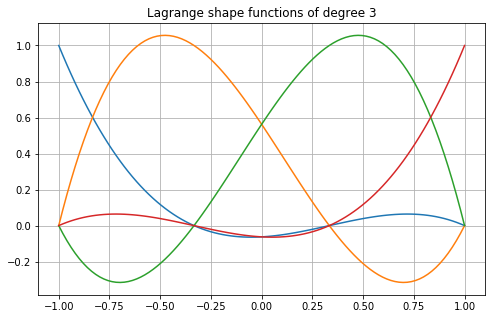

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import fixed_quad
import fembase as fem

degree = 3
# polynomial degree
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# check the docstring to see what this does
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
svec = np.linspace(-1,1,100)

for i in range(shapefun.d + 1):
    ax.plot(svec, shapefun.eta[i](svec))
    
ax.grid()
ax.set(title='Lagrange shape functions of degree ' + str(shapefun.d))
plt.show()

The actual basis functions $\varphi_i^0$ are related to the shape functions $\eta_n$ via the mappings $F_i$ from \eqref{F}-\eqref{Finv}. Since there are many different indices involved, let us clarify:

$$
\ba
 &\tn{elements:} &&\Omega_k, \quad k = 1,\ldots, N_\tn{el} \,,
 \\[2mm]
 &\tn{basis\,functions:} &&\varphi_i^0,\quad i = 1, \ldots, N_0\,,
 \\[2mm]
 &\tn{shape\,functions:} &&\eta_n,\quad n = 0,\ldots, d\,.
\ea
$$

Let us compute the number $N_0$ of Lagrange basis functions for the space $V_0$. In each element we have $d+1$ shape functions, such that the total number of degrees of freedom (DOF) is $N_\tn{tot} = N_\tn{el}(d+1)$. In order to guarantee continuity, the element interfaces must be shared degrees of freedom and are only counted once. Hence, the number of basis functions is $N_0 = N_\tn{tot} - (N_\tn{el} - 1) - bcs$, where $bcs$ depends on the boundary conditions. For homogeneous Dirichlet conditions we remove the leftmost and the rightmost DOF, thus $bcs = 2$. For periodic conditions no DOF is removed, but the first and the last DOF are shared, thus $bcs = 1$. The relation between the different indices is described in the following tables.

Table 1: <b>Dirichlet boundary conditions</b> ($bcs = 2$), $\quad N_0 = N_\tn{el}d - 1$.

$$
 \begin{array}{c|c|c}
 \tn{element} & \tn{basis\,function} & \tn{shape\, function}
 \\[0mm]
 k & i & n
 \\[1mm] \hline
 1 & 1,\ldots, d  & 1,\ldots,d 
 \\[1mm]
 2 & d,\ldots, 2d & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 k & (k-1)d,\ldots, kd  & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 N_\tn{el} & (N_\tn{el} - 1)d,\ldots, N_\tn{el}d - 1 & 0,\ldots,d - 1
 \end{array}\,.
$$

This means that in the first element we have the basis functions $\varphi_i^0$ with the indices $i = n $ for $n = 1,\ldots,d$, in the $k$-th element ($1 < k < N_\tn{el}$) we have the basis functions $i = (k-1)d + n$ with $n = 0,\ldots,d$ and in the $N_\tn{el}$-th element we have the basis functions $i = (N_\tn{el} - 1)d + n$ with $n = 0, \ldots, d-1$. From the above table we can deduce the correct indices for relating the basis functions to the shape functions via 

$$
\be
 \eta_n(s) = (\varphi_i^0 \circ F_k)(s)\,.  \label{phi-to-shape}
\ee
$$

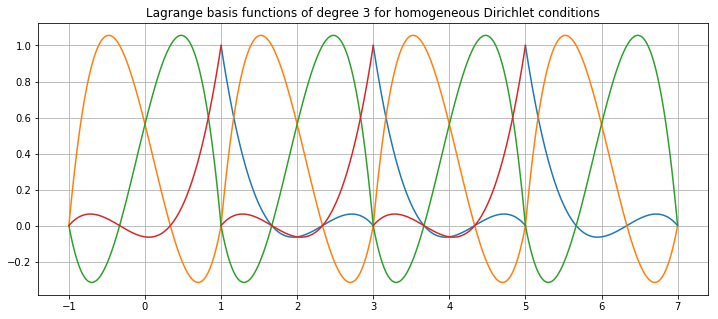

In [2]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d + 1):
    
    if i == 0:
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    elif i == shapefun.d:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    else:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' 
               + str(shapefun.d) + ' for homogeneous Dirichlet conditions')

plt.show()

Table 2: <b>Periodic boundary conditions</b> ($bcs = 1$), $\quad N_0 = N_\tn{el}d$.

$$
 \begin{array}{c|c|c}
 \tn{element} & \tn{basis\,function} & \tn{shape\, function}
 \\[0mm]
 k & i & n
 \\[1mm] \hline
 1 & 0,\ldots, d & 0,\ldots,d 
 \\[1mm]
 2 & d,\ldots, 2d & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 k & (k-1)d,\ldots, kd & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 N_\tn{el} & (N_\tn{el} - 1)d,\ldots, N_\tn{el}d - 1,\, 0 & 0,\ldots,d 
 \end{array}\,.
$$

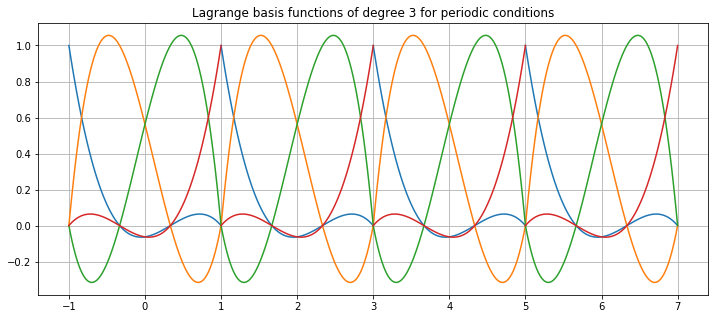

In [3]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d + 1):

    ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' 
               + str(shapefun.d) + ' for periodic conditions')

plt.show()

Any function $E_h \in V_0$ can be expanded in the basis $(\varphi^0_i)_{1\leq i\leq N_0}$. Supposing that $E_h$ is time dependent, we write 

$$
\be
 E_h(t,x) = \sum_{i=1}^{N_0} e_i(t)\, \varphi^0_i(x)\,.   \label{def:Eh}
\ee
$$

Here, the vector $\bold e = (e_i)_{1\leq i\leq N_0} \in \RR^{N_0}$ holds the (time dependent) coefficients with respect to the basis. We shall introduce the node vector $\bold x =(x_i)_{0\leq i\leq N_0+1}\in \RR^{N_0+2}$, holding the domain boundaries $x_0 = a$ and $x_{N_0+1} = b$ as well as the nodes that define the Lagrange basis functions, hence $\varphi^0_i(x_j) = \delta_{i,j}$ for $1\leq i\leq N_0$. The element boundaries $ (c_k)_{1\leq k\leq N_\tn{el}-1}$ are obviously a subset of the elements of $\bold x$. From \eqref{def:Eh} it follows that $E_h(t, x_j) = e_j(t)$. 

Going back to our diagram, the first projector $\Pi_0$ will be just the <b>Lagrange interpolation</b>: 

$$
\be
 \Pi_0: H^1_0 \to V_0,\quad \tn{defined\ by}\quad (\Pi_0E)(x_i) = E(x_i)\quad \forall\ i \in \{1,\ldots,N_0 \} \,.
\ee
$$

Denoting $\Pi_0 E = E_h$ we have $E_h(x_j) = e_j = E(x_j)$. Remark that it makes sense to evaluate $E\in H_0^1$ at any point $x\in (a,b)$ because $E$ is continuous.

### Lagrange histopolation 

Let us now consider the space $V_1 \subset L^2$. Its elements are piece-wise continuous functions. A basis will be once again defined from shape functions on the reference element $I = [-1, 1]$. Taking the same knot sequence $s_0 = -1 < \ldots < s_d = 1 \in I$ as for the Lagrange polynomials defined by \eqref{def:Lag}, the <i>Lagrange histopolation polynomials</i> (LHPs) $\chi_{n+1/2}$ are defined by 

$$
\be \label{def:chi}
 \int_{s_m}^{s_{m+1}}\chi_{n+1/2}(s)\,\tn d s = \delta_{n,m}\,,\qquad n,m = 0,\ldots d-1\,.
\ee
$$

In order to solve these equations we introduce polynomials $\Phi_{n+1/2}$ of degree $d$ such that $\chi_{n+1/2} = \ds{}\Phi_{n+1/2}$. Performing integration in \eqref{def:chi} then yields

$$
\be
 \Phi_{n+1/2}(s_{m+1}) - \Phi_{n+1/2}(s_m) = \delta_{n,m}\,.
\ee
$$

We can solve these equations by Lagrange interpolation. For $n$ fixed, we have $d$ equations for $d+1$ unknowns. Therefore, we are allowed to add the condition $\Phi_{n+1/2}(s_n) = 0$. This just fixes the constant in $\Phi_{n+1/2}$ and does not inlfuence the result for $\chi_{n+1/2}$. We obtain the equations

$$
\ba
 &\Phi_{n+1/2}(s_n) = 0\,,
 \\[1mm]
 &\Phi_{n+1/2}(s_{n+1}) = 1\,,
 \\[1mm]
 &\Phi_{n+1/2}(s_{m+1}) - \Phi_{n+1/2}(s_m) = \delta_{n,m}\qquad \tn{for}\ m\neq n\,.
\ea
$$

By Lagrange interpolation, the solution is 

$$
\be
 \Phi_{n+1/2}(s) = \sum_{m = n+1}^d \eta_m(s)\,,
\ee
$$

where $\eta_m$ denote the Lagrange shape functions defined above. It follows that the LHPs are given by

$$
\be
 \chi_{n+1/2}(s) = \sum_{m = n+1}^d \ds{} \eta_m(s)\,,\qquad n = 0,\ldots,d-1\,.
\ee
$$

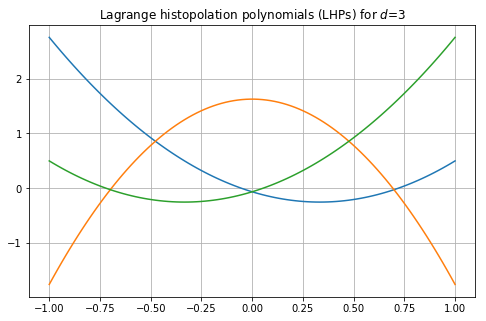

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
svec = np.linspace(-1,1,100)

# initiate the list of LHPs
for i in range(shapefun.d):  
    ax.plot(svec, shapefun.chi[i](svec))
    
ax.grid()
ax.set(title='Lagrange histopolation polynomials (LHPs) for $d$=' + str(shapefun.d))
plt.show()

Let us test the defining property \eqref{def:chi} of LHPs:

$$
\be
\begin{aligned}
 \int_{s_m}^{s_{m+1}}\chi_{n+1/2}(s)\,\tn d s 
 &= \sum_{l = n+1}^d \int_{s_m}^{s_{m+1}}\ds{} \eta_l(s)\,\tn d s
 \\[0mm]
 &= \sum_{l = n+1}^d [ \eta_l(s_{m+1}) - \eta_l(s_m) ]
 \\[2mm]
 &= \eta_{n+1}(s_{m+1}) \underbrace{- \eta_{n+1}(s_m) + \eta_{n+2}(s_{m+1})}_{=0} \underbrace{- \eta_{n+2}(s_m) + \ldots}_{=0} - \eta_{d}(s_m)
 \\[0mm]
 &= \eta_{n+1}(s_{m+1}) - \eta_{d}(s_m)\,.
 \end{aligned}
\ee
$$

Since $m \in\{ 0,\ldots,d-1 \}$ the last term is always zero, which yields the desired result. Let us verify this also numerically:

In [5]:
print('n', 'm', 'delta_nm\n', sep='   ')
for i in range(shapefun.d):
    antider = np.polyint(shapefun.chi[i])
    for j in range(shapefun.d):
        delta_nm = antider(shapefun.s[j + 1]) - antider(shapefun.s[j])
        print(i, j, delta_nm, sep='   ')

n   m   delta_nm

0   0   1.0
0   1   6.245004513516506e-17
0   2   -9.020562075079397e-17
1   0   2.220446049250313e-16
1   1   0.9999999999999998
1   2   -5.551115123125783e-17
2   0   -6.938893903907228e-17
2   1   -6.938893903907228e-18
2   2   1.0


The actual basis functions $\varphi_{i+1/2}^1$ are related to the shape functions $\chi_{n+1/2}$ via the mappings $F_k$ from \eqref{F}-\eqref{Finv}. Again, let us clarify the indices:

$$
\ba
 &\tn{elements:} &&\Omega_k, \quad k = 1,\ldots, N_\tn{el} \,,
 \\[2mm]
 &\tn{basis\,functions:} &&\varphi_{i+1/2}^1,\quad i = 0, \ldots, N_1 - 1\,,
 \\[2mm]
 &\tn{shape\,functions:} &&\chi_{n+1/2},\quad n = 0,\ldots, d-1\,.
\ea
$$

The number $N_1$ of LHP basis functions for the space $V_1$ is $d$ per element, hence $N_1 =  N_\tn{el}d$. In the $k$-th element we have the basis functions $\varphi^1_{i+1/2}$ with $i = (k-1)d + n$ with $n = 0,\ldots,d-1$. From this we can deduce the correct indices for relating the basis functions to the shape functions via 

$$
\be
 \chi_{n+1/2}(s) = (\varphi_{i+1/2}^1 \circ F_k)(s)\,,\qquad \tn{where} \quad n = \tn{mod}(i,d)\,.  \label{chi-to-shape}
\ee
$$

For a basis function defined in the $k$-th element we obtain

$$
\be
 \int_{x_j}^{x_{j+1}} \varphi^1_{i+1/2}(x)\,\tn d x = \frac{c_k - c_{k-1}}{2} \int_{s_m}^{s_{m+1}} \chi_{n+1/2}(s) \,\tn ds = \frac{c_k - c_{k-1}}{2}\,\delta_{n,m}\,.
\ee
$$

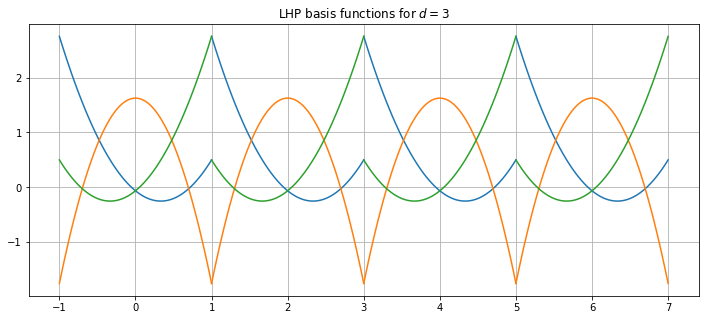

In [6]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d):

    ax.plot(svec, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 2, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 4, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 6, shapefun.chi[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='LHP basis functions for $d=$' + str(shapefun.d))

plt.show()

For $B_h \in V_1$, time-dependent, we write

$$
\be
 B_h(t, x) = \sum_{i=0}^{N_1-1} b_{i+1/2}(t)\, \varphi^1_{i+1/2}(x)\,.   \label{def:Bh}
\ee
$$

For $[x_j,x_{j+1}] \in \Omega_k$ it follows that

$$
\be
 \int_{x_j}^{x_{j+1}} B_h(t, x)\,\tn d x = \frac{c_k - c_{k-1}}{2}\,b_{j+1/2}(t)\,.
\ee
$$

As the second projector in our diagram we choose the <b>Lagrange histopolation</b>:

$$
\be
 \Pi_1: L_2 \to V_1,\quad \tn{defined\ by}\quad \int_{x_i}^{x_{i+1}}(\Pi_1B)(x)\,\tn d x = \int_{x_i}^{x_{i+1}} B(x)\,\tn d x\quad \forall\ i \in \{0,\ldots,N_0\} \,.
\ee
$$

Remark that these integrals are well defined because $B$ is piece-wise continuous. Denoting $\Pi_1B = B_h$ from equation \eqref{def:Bh}, the above definition of the Lagrange histopolant yields

$$
\be
 \frac{c_k - c_{k-1}}{2}\,b_{j+1/2} = \int_{x_j}^{x_{j+1}} B(x)\,\tn d x\qquad \tn{for}\quad [x_j,x_{j+1}] \in \Omega_k \,.
\ee
$$


### Commuting diagram property

Let us now prove that, with the projections defined above, the diagram

<img src="pics/deRham1D.png" width="220"/>

is indeed a commuting diagram. For this take a function $E\in H^1_0$ and project it to $V_0$, yielding $E_h = \Pi_0 E$. Now we take the derivative of $E_h$ expanded in the basis $(\varphi_i^0)_{1\leq i\leq N_0}$:

$$
\be
 \pder{}{x} (\Pi_0E)(x) = \sum_{i=1}^{N_0} e_i\,  \pder{}{x}\varphi^0_i(x)\,.   
\ee
$$

Let us verify that this defines a unique element in $V_1$. Indeed, assuming

$$
\be
 \pder{}{x} (\Pi_0E)(x) = \sum_{i=0}^{N_1-1} e'_{i+1/2}\,  \varphi^1_{i+1/2}(x)\,,  
\ee
$$

we get the following unique epxressions for the coefficients $e'_{i+1/2}$:

$$
\be \label{comm:proof1}
\begin{aligned}
 e'_{i+1/2} &= \int_{x_i}^{x_{i+1}} \pder{}{x} (\Pi_0E)(x)\,\tn d x 
 \\
 &= \sum_{j=0}^{N_0-1} e_j \int_{x_i}^{x_{i+1}} \pder{}{x}\varphi^0_j(x)\,\tn d x 
 \\
 &= \sum_{j=0}^{N_0-1} e_j\, [ \varphi^0_j(x_{i+1}) - \varphi^0_j(x_i) ]
 \\[1mm]
 &=  e_{i+1} - e_i\,.
\end{aligned}
\ee
$$

Remark that for Dirichlet conditions we have $e_0 = e_{N_1} = 0$.
On the other hand, let us project $\pder{}{x} E\in L^2$ to $V_1$, yielding

$$
\be
 \Pi_1 \pder{}{x} E(x)  = \sum_{i=0}^{N_1-1} f_{i+1/2}(t)\,  \varphi^1_{i+1/2}(x)\,,
\ee
$$

where by definition of $\Pi_1$ the coefficients $f_{i+1/2}$ are given by

$$
\be \label{comm:proof2}
\begin{aligned}
 f_{i+1/2} &= \int_{x_1}^{x_{i+1}} \pder{}{x} E (x)\,\tn d x 
 \\[1mm]
 &= E(x_{i+1}) - E(x_i)
 \\[3mm]
 &= e_{i+1} - e_{i}\,.
\end{aligned}
\ee
$$

By comparison of \eqref{comm:proof1} and \eqref{comm:proof2} we prove that

$$
\be
 \pder{}{x} \Pi_0 E = \Pi_1 \pder{}{x} E\,,
\ee
$$

and hence the diagram is commuting.


### Linear system of equations

Let us come back to the discrete system \eqref{disc:1} - \eqref{disc:3}. Faraday's law is satisfied in a strong sense because we did not integrate by parts. This means that we can write the equation directly for each of the coefficients in the basis of $V_1$. Let us derive this nevertheless from the weak formulation. In 

$$
 \be  \label{Faraday:disc}
 \int_a^b \pder{B_h}{t} C_h\,\tn d x + \int_a^b \pder{E_h}{x} C_h\,\tn d x = 0 \qquad \forall\, C_h \in V_1\,,
 \ee
$$

we write

$$
\be
 B_h(t,x) = \sum_{i=0}^{N_1-1} b_{i+1/2}(t)\, \varphi^1_{i+1/2}(x)\,, \qquad  C_h(x) = \sum_{i=0}^{N_1-1} c_{i+1/2}\, \varphi^1_{i+1/2}(x)\,. 
\ee
$$

with $\bold b = (b_{i+1/2})_{0\leq i\leq N_1 -1} \in \RR^{N_1}$, $\bold c = (c_{i+1/2})_{0\leq i\leq N_1 -1} \in \RR^{N_1}$, and

$$
\be
 E_h(t,x) = \sum_{i=1}^{N_0} e_i(t)\, \varphi^0_i(x)\,,\qquad \pder{E_h}{x}(t,x)= \sum_{i=0}^{N_1-1} [e_{i+1}(t) - e_i(t)]\, \varphi^1_{i+1/2}(x)\,,
\ee
$$

where $e_0 = e_{N_1} = 0$ and $\bold e = (e_i)_{1\leq i\leq N_0}\in\RR^{N_0}$. Inserted into \eqref{Faraday:disc} this yields

$$
\be
 \sum_{i,j=0}^{N_1-1} \pder{b_{i+1/2}}{t}\,c_{j+1/2} \underbrace{\int_a^b \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{= M^1_{ij}} + \sum_{i,j=0}^{N_1-1} [e_{i+1} - e_i]\,c_{j+1/2} \underbrace{\int_a^b \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{= M^1_{ij}} = 0 \,.
\ee
$$

Introducing the gradient matrix $\GG_0 \in \RR^{N_1 \times N_0}$,

$$
\be
 \GG_0 := \begin{pmatrix}
 1 &   &  &  &  & 
 \\
 -1 & 1 &  & &  & 
 \\
  & -1 & 1 &   &  & 
 \\
  &  & \ddots & \ddots &  & 
 \\
  & &  & -1 & 1 & 
 \\
  &  &  & & -1 & 1
 \\
  &  &  &  &  & -1  
 \end{pmatrix}\,,
\ee
$$

and the mass matrix $\MM^1 = (M^1_{ij})_{0\leq i,j,\leq N_1-1} \in \RR^{N_1 \times N_1}$, we can write this compactly as

$$
\be
 \pder{\bold b}{t}\, \MM^1\, \bold c + \GG_0\,\bold e \,\MM^1\, \bold c = 0 \,.
\ee
$$

Since this is true for all $\bold c \in \RR^{N_1}$ we obtain

$$
\be
 \pder{\bold b}{t} + \GG_0\,\bold e = 0 \,.
\ee
$$

This form is independent of the chosen polynomial degree.

Let us now consider the $y$-component of Ampère's law:

$$
\be \label{Ampere2:disc}
\frac{1}{c^2} \int_a^b \pder{E_h}{t} F_h\,\tn d x - \int_a^b B_h\,\pder{F_h}{x} \,\tn d x = - \mu_0 \int_a^b (\Pi_0 j) \,F_h\,\tn d x \qquad \forall\, F_h \in V_0\,.
\ee
$$

We write 

$$
\be
 F_h(x) = \sum_{i=1}^{N_0} f_i\, \varphi^0_i(x)\,,\qquad \pder{F_h}{x}(x)= \sum_{i=0}^{N_1-1} [f_{i+1} - f_i]\, \varphi^1_{i+1/2}(x)\,,
\ee
$$

with $\bold f = (f_i)_{1\leq i\leq N_0} \in \RR^{N_0}$ and

$$
\be
 (\Pi_0 j)(t,x) = \sum_{i=1}^{N_0} j_i(t)\, \varphi^0_i(x)\,,\qquad \tn{with} \quad j_i(t) = j(t,x_i)\,,\quad \bold j = (j_i)_{1\leq i\leq N_0} \in \RR^{N_0}\,.
\ee
$$

Inserting this into \eqref{Ampere2:disc} yields

$$
\be
\begin{aligned}
 &\frac{1}{c^2} \sum_{i,j=1}^{N_0} \pder{e_i}{t}\, f_j \underbrace{\int_a^b \varphi^0_i\,\varphi^0_j\,\tn d x}_{=M^0_{ij}} - \sum_{i,j=0}^{N_1-1} b_{i+1/2}[f_{j+1} - f_j] \underbrace{\int_a^b  \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{=M^1_{ij}}
 \\
  &\qquad = - \mu_0 \sum_{i,j=1}^{N_0} j_i\,f_j \underbrace{\int_a^b \varphi^0_i\,\varphi^0_j\,\tn d x}_{=M^0_{ij}} \,.
\end{aligned}
\ee
$$

We can write this compactly as

$$
\be
 \frac{1}{c^2} \pder{\bold e}{t}\, \MM^0\, \bold f - \bold b\, \MM^1 \GG_0\, \bold f 
  = - \mu_0\, \bold j \, \MM^0\, \bold f\qquad \forall\ \bold f \in \RR^{N_0} \,.
\ee
$$

Cancelling $\bold f$ leads to the linear system

$$
\be
 \frac{1}{c^2} \pder{\bold e}{t} -  (\MM^0)^{-1}\GG_0^\top \MM^1 \bold b 
  = - \mu_0\, \bold j \,.
\ee
$$

The $x$-component of Ampère's law \eqref{disc:1} is given in strong form,

$$
\be
 \pder{\bold e_x}{t} = -\mu_0\,\bold j_x\,,
\ee
$$

where $\bold e_x = (e_{x,i})_{0\leq i\leq N_0} \in \RR^{N_0+1}$ and $\bold j_x = (j_{x,i})_{0\leq i\leq N_0} \in \RR^{N_0+1}$ are the coefficients in the basis of $\tilde V_0$ (the 'tilde' indicates periodic boundary conditions), denoted $(\tilde \varphi^0_i)_{0\leq i\leq N_0}$. For example,

$$
\be
 E_{x,h}(t,x) = \sum_{i=0}^{N_0} e_{x,i}(t)\,\tilde \varphi^0_i(x)\,.
\ee
$$

In summary, the system \eqref{disc:1} - \eqref{disc:3} for the coefficients $\bold e_x\in \RR^{N_0+1}$, $(\bold e, \bold b) \in \RR^{N_0}\times \RR^{N_1}$ reads

$$
\ba
 & \pder{\bold e_x}{t} = -\mu_0\,\bold j_x\,,
 \\[1mm]
  \frac{1}{c^2} & \pder{\bold e}{t} -  (\MM^0)^{-1}\GG_0^\top \MM^1 \bold b 
  = - \mu_0\, \bold j\,,
 \\[1mm]
 & \pder{\bold b}{t} + \GG_0\,\bold e = 0\,.
\ea
$$

## Coupling to a particle-in-cell (PIC) solver 

Maxwell's equations are coupled to the plasma by means of the charge density $\varrho$ and the current density $\bold J$. The plasma dynamics can be described for example by Vlasov equations for each particle species $s$:

$$
\be
 \pder{}{t}\, f_s + \bold v \cdot \nabla_x f_s + \frac{q_s}{m_s}(\bold E + \bold v \times \bold B)\cdot \nabla_v f_s = Q(f_s)\,. 
\ee
$$

Here, $f_s = f_s(t,\bold x, \bold v)$ is the particle distribution function of species $s$, $\bold x$ stands for the particle position, $\bold v$ denotes the particle velocity, $q_s$ and $m_s$ denote the species' charge and mass, respectively, and $Q$ is a collision operator. The charge and current densities are defined by

$$
\ba
 \varrho(t,\bold x) &:= \sum_s q_s \int_{\RR^3} f_s(t,\bold x,\bold v)\,\tn d^3\bold v\,,
 \\[1mm]
 \bold J(t,\bold x) &:= \sum_s q_s\int_{\RR^3} \bold v\, f_s(t,\bold x,\bold v)\,\tn d^3\bold v\,.
\ea
$$

In our 1D test case we consider only variations with respect to $x$, $v_x$ and $v_y$. We also work in the collision-less case, $Q = 0$. Moreover, $E_z = B_x = B_y = 0$ has been assumed, such that

$$
\be
 \pder{}{t}\, f_s + v_x \pder{}{x} f_s + \frac{q_s}{m_s}(E_x + v_y B) \pder{}{v_x} f_s + \frac{q_s}{m_s}(E - v_x B) \pder{}{v_y} f_s = 0\,. 
\ee
$$

The characteristic equations of this PDE read

$$
\ba
 \dt{x} &= v_x\,,
 \\[1mm]
 \dt{v_x} &= \frac{q_s}{m_s}(E_x + v_y B)\,,
 \\[1mm]
 \dt{v_y} &= \frac{q_s}{m_s}(E - v_x B)\,,
\ea
$$

subjected to suitable initial conditions.